In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

from load_dataset_title import get_dataset

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint,EarlyStopping

from gensim.models import KeyedVectors
from gensim.models import FastText as ft

from keras import layers, models, optimizers
from keras.regularizers import l2
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Conv1D,MaxPooling1D,Dropout,GlobalMaxPool1D,SpatialDropout1D,AveragePooling1D,GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization

import regex as re
from imblearn.over_sampling import RandomOverSampler
import random as random


cwd = os.getcwd()

Using TensorFlow backend.


In [2]:
##Load the word embeddings

embed_model2 = ft.load_fasttext_format("cc.en.300.bin")

vec_dim = len(embed_model2["cat"])

c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [3]:
#Standard thing to do for NLP tasks, apparently.
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [18]:
#df_size = "large" is to load the large dataset, "small" is to load the small dataset.

# sampling_method = "oversample"
# sampling_method = "undersample"
sampling_method = "none"

def get_train_and_test(df_size = "large", sampling_method = None, percentage = 0.2):
    def generate_balanced_dataset_undersampling(df): #nested helper function to generate balanced datasets
        only_nonclickbait = df.loc[df['label'] == "0"]
        only_clickbait = df.loc[df['label'] == "1"]

        while len(only_nonclickbait)!= len(only_clickbait):
            to_drop = random.randint(0, len(only_nonclickbait) - 1)
            only_nonclickbait = only_nonclickbait.drop(only_nonclickbait.index[to_drop])

        frames = [only_clickbait, only_nonclickbait]
        final_balanced_dataset = pd.concat(frames)
        print("Done generating balanced dataset via undersampling")
        return final_balanced_dataset

    df = get_dataset(size = df_size) #use small for small dataset, large for large dataset. Will print the number of articles loaded.
    
    if sampling_method == "oversample":
        X = df["title"].apply(preprocess_text)
        y = df['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state = 51)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = percentage, random_state = 51)
        ros = RandomOverSampler(random_state=0)
        X_train_resized = X_train.reshape(-1,1)
        X_train, y_train = ros.fit_resample(X_train_resized, y_train)
        X_train = X_train.flatten()
        return X_train, X_val, X_test, y_train, y_val, y_test
    elif sampling_method == "undersample":
        df_balanced = generate_balanced_dataset_undersampling(df)
        df_balanced = df_balanced.sample(frac=1)
        X = df_balanced["title"].apply(preprocess_text)
        y = df_balanced['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state=51)
        return X_train, X_test, y_train, y_test
    else:
        print("Neither undersampling nor oversampling specified")
        X = df["title"].apply(preprocess_text)
        y = df['label'].astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = percentage, random_state=51)
        return X_train, X_test, y_train, y_test

if sampling_method == "oversample":
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_and_test(df_size = "large", sampling_method = sampling_method)
    pass
elif sampling_method == "undersample":
    X_train, X_test, y_train, y_test = get_train_and_test(df_size = "large", sampling_method = "undersample")
else:
    X_train, X_test, y_train, y_test = get_train_and_test(df_size = "large", sampling_method = "None")
    pass

print("No. of training examples:", len(X_train))
print("No. of testing examples:", len(X_test))

loading large document
19539 data entries loaded
Neither undersampling nor oversampling specified
No. of training examples: 15630
No. of testing examples: 3908


In [19]:
"""
Purpose of this cell is to pre-process the article titles by:
1. Tokenizing
2. Encoding a vector of words as a vector of numbers
3. Post-padding it with zeros
The length of all the article titles is set to the length of the longest title.

"""

def get_max_length():
    t = Tokenizer()
    t.fit_on_texts(X_train)
    encoded_X = t.texts_to_sequences(X_train)
    max_length = 0
    for i in encoded_X:
        max_length = max(len(i), max_length)
    return max_length + 1

input_length = get_max_length()
print("Max length of title is:", input_length)

def pre_process_input(array):
    t = Tokenizer()
    t.fit_on_texts(array)
    vocab_size = len(t.word_index) + 1
    encoded_X = t.texts_to_sequences(array)

    ##input_length is a global variable
    padded_X = pad_sequences(encoded_X, maxlen = input_length,
                          padding = "post")
    
    return (padded_X, t)

#Create the padded X_test data as well as the padded X_train data
padded_X_train, t_train = pre_process_input(X_train)
vocab_size = len(t_train.word_index) + 1
input_length = len(padded_X_train[0])
padded_X_test = pre_process_input(X_test)[0]
if sampling_method == "oversample":
    padded_X_val = pre_process_input(X_val)[0]

Max length of title is: 219


In [6]:
#Create the embedding matrix using the training data,
embedding_matrix = np.zeros((vocab_size, vec_dim))
for word,i in t_train.word_index.items():
    embedding_vector = embed_model2[word]
    embedding_matrix[i] = embedding_vector

c:\python 3.6.4\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## Model: 1-D Convolutional Neural Network

In [10]:
"""
Train the model
"""
#Hyper-Params
epochs = 100 #50 orig
batch_size = 32 #for stochastic gradient descent
drop_embed = 0.3 #0.2 orig

n_dense = 100
dropout = 0.5 #0.5 orig

n_conv_layer1 = 16
n_conv_layer2 = 14
n_conv_layer3 = 12
n_conv_layer4 = 10
k_conv = 3

#Define model

model = Sequential()
e = Embedding(vocab_size, vec_dim, weights = [embedding_matrix],
              input_length = input_length, trainable = False)
model.add(e)
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(filters = n_conv_layer1, kernel_size = k_conv, activation = "relu", padding = "same"))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters = n_conv_layer2, kernel_size = k_conv, activation = "relu", padding = "same"))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters = n_conv_layer3, kernel_size = k_conv, activation = "relu", padding = "same"))
model.add(GlobalMaxPool1D())
model.add(Dropout(dropout))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### summarize the model
print(model.summary())



### Create model checkpoints
if sampling_method == "oversample":
    ending_str = "/model_weights_oversampling.{epoch:02d}-{val_loss:.3f}.hdf5"
elif sampling_method == "undersample":
    ending_str = "/model_weights_undersampling.{epoch:02d}-{val_loss:.3f}.hdf5"
else:
    ending_str = "/model_weights_imbalanced_training_data.{epoch:02d}-{val_loss:.3f}.hdf5"

output_dir = cwd
modelcheckpoint = ModelCheckpoint(filepath = output_dir + ending_str,
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint, EarlyStopping(monitor = "val_loss", patience = 4)]

callbacks_list_no_chkpt = [EarlyStopping(monitor = "val_loss", patience = 2)]

## fit the model
if sampling_method == "oversample":
    model.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_data = (padded_X_val, y_val), callbacks = callbacks_list)
else:
    model.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.2, callbacks = callbacks_list)

#fit with no checkpointing
# if sampling_method == "oversampling":
#     model.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_data = (X_val, y_val), callbacks = callbacks_list_no_chkpt)
# else:
#     model.fit(padded_X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split = 0.2, callbacks = callbacks_list_no_chkpt)


print("Model training complete")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 219, 300)          4024800   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 219, 300)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 219, 16)           14416     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 109, 16)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 109, 14)           686       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 54, 14)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 54, 12)           

['loss', 'accuracy']
3908/3908 [==============================] - 1s 220us/step
[0.5657322529547046, 0.7607471942901611]
Confusion matrix for training data
[[11413   375]
 [ 2530  1312]]
Confusion matrix for testing data
[[2921   68]
 [ 867   52]]
Confusion matrix for test data:
The F1 score is: 0.10009624639076034


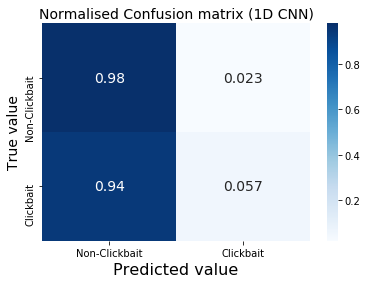

figure saved


In [20]:
"""
Here we evaluate the model to find the test loss and accuracy
"""

if sampling_method == "oversample":
    model_loaded = load_model("model_weights_oversampling.03-0.670.hdf5")
elif sampling_method == "undersample": #somehow this leads to error...dunno why sia sian.
    model_loaded = load_model("model_weights_undersampling.09-0.600.hdf5")
else:
    model_loaded = load_model("model_weights_imbalanced_training_data.10-0.459.hdf5")
    
print(model_loaded.metrics_names)
print(model_loaded.evaluate(x=padded_X_test, y=y_test, verbose = 1))

"""
Here we print the confusion matrices for both training and test,
and plot the confusion matrices for the test data.

We also print the F1 score for the test data.
"""
def plot_cm_n_calculate_F1_score(confusion_matrix, normalise = True, fig_name = None):

    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("The F1 score is:", F1_score)
    
    cm = [[0,0],[0,0]]
    if normalise:
        cm[0][0] = TN / (TN + FP)
        cm[0][1] = FP / (TN + FP)
        cm[1][0] = FN / (FN + TP)
        cm[1][1] = TP / (FN + TP)
        plt.title('Normalised Confusion matrix (1D CNN)', fontsize = 14)
    else:
        cm[0][0] = TN
        cm[0][1] = FP
        cm[1][0] = FN
        cm[1][1] = TP
        plt.title('Confusion matrix (1D CNN)', fontsize = 14)
        
    labels = ['Non-Clickbait', 'Clickbait']
    df_cm = pd.DataFrame(cm, index = labels, columns = labels,)
    sns_plot = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, annot_kws={"size": 14})
    fig = sns_plot.get_figure()
    plt.xlabel('Predicted value', fontsize = 16)
    plt.ylabel('True value', fontsize = 14)
    plt.show()
    
    if fig_name:
        fig.savefig(fig_name)
        print("figure saved")

    
#Printing confusion matrix for training data
y_train_pred = model_loaded.predict(padded_X_train)
y_train_pred = np.array([1 if i > 0.5 else 0 for i in y_train_pred])
print("Confusion matrix for training data")
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion_matrix_train)

#Printing confusion matrix for training data
y_test_pred = model_loaded.predict(padded_X_test)
y_test_pred = np.array([1 if i > 0.5 else 0 for i in y_test_pred])
print("Confusion matrix for testing data")
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion_matrix_test)

#Plotting the test data normalised confusion matrix
print("Confusion matrix for test data:")

if sampling_method == "oversample":
    plot_cm_n_calculate_F1_score(confusion_matrix_test, fig_name = "Normalised_confusion_matrix_oversampling_test.png")
elif sampling_method == "undersample":
    plot_cm_n_calculate_F1_score(confusion_matrix_test, fig_name = "Normalised_confusion_matrix_undersampling_test.png")
else:
    plot_cm_n_calculate_F1_score(confusion_matrix_test, fig_name = "Normalised_confusion_matrix_inbalancedsampling_test.png")